# BUI analyse d'un centre commercial
## Julien(Billeter, Muhlemann)

In [40]:
import numpy as np
import pandas as pd
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt

path = "data/"
filename = "marketing_campaign.csv"
def load_df(path=path, filename=filename):
    file_path = os.path.join(path, filename)
    data_df = pd.read_csv(file_path, sep='\t')
    return data_df




In [41]:

def clean_df(data_df):
    num_df = data_df.select_dtypes(include='number')
    imputer = KNNImputer(missing_values=np.nan, n_neighbors=3)  # SimpleImputer(strategy='mean')
    imputed_num_df = pd.DataFrame(imputer.fit_transform(num_df), columns=num_df.columns)

    # Remove columns with std = 0
    imputed_num_df = imputed_num_df.loc[:, imputed_num_df.std() != 0]

    scaler = RobustScaler()
    non_num_df = data_df.select_dtypes(exclude='number')
    data_scaled = scaler.fit_transform(imputed_num_df)

    data_scaled_df = pd.DataFrame(data_scaled, columns=imputed_num_df.columns, index=imputed_num_df.index)
    final_df = pd.concat([data_scaled_df, non_num_df], axis=1)
    return final_df

data_df = load_df()
final_df = clean_df(data_df)

data_numerical = final_df.select_dtypes(include='number').copy()
data_non_numerical = final_df.select_dtypes(exclude='number').copy()

https://cedric.cnam.fr/vertigo/Cours/ml/tpDonneesManquantes.html

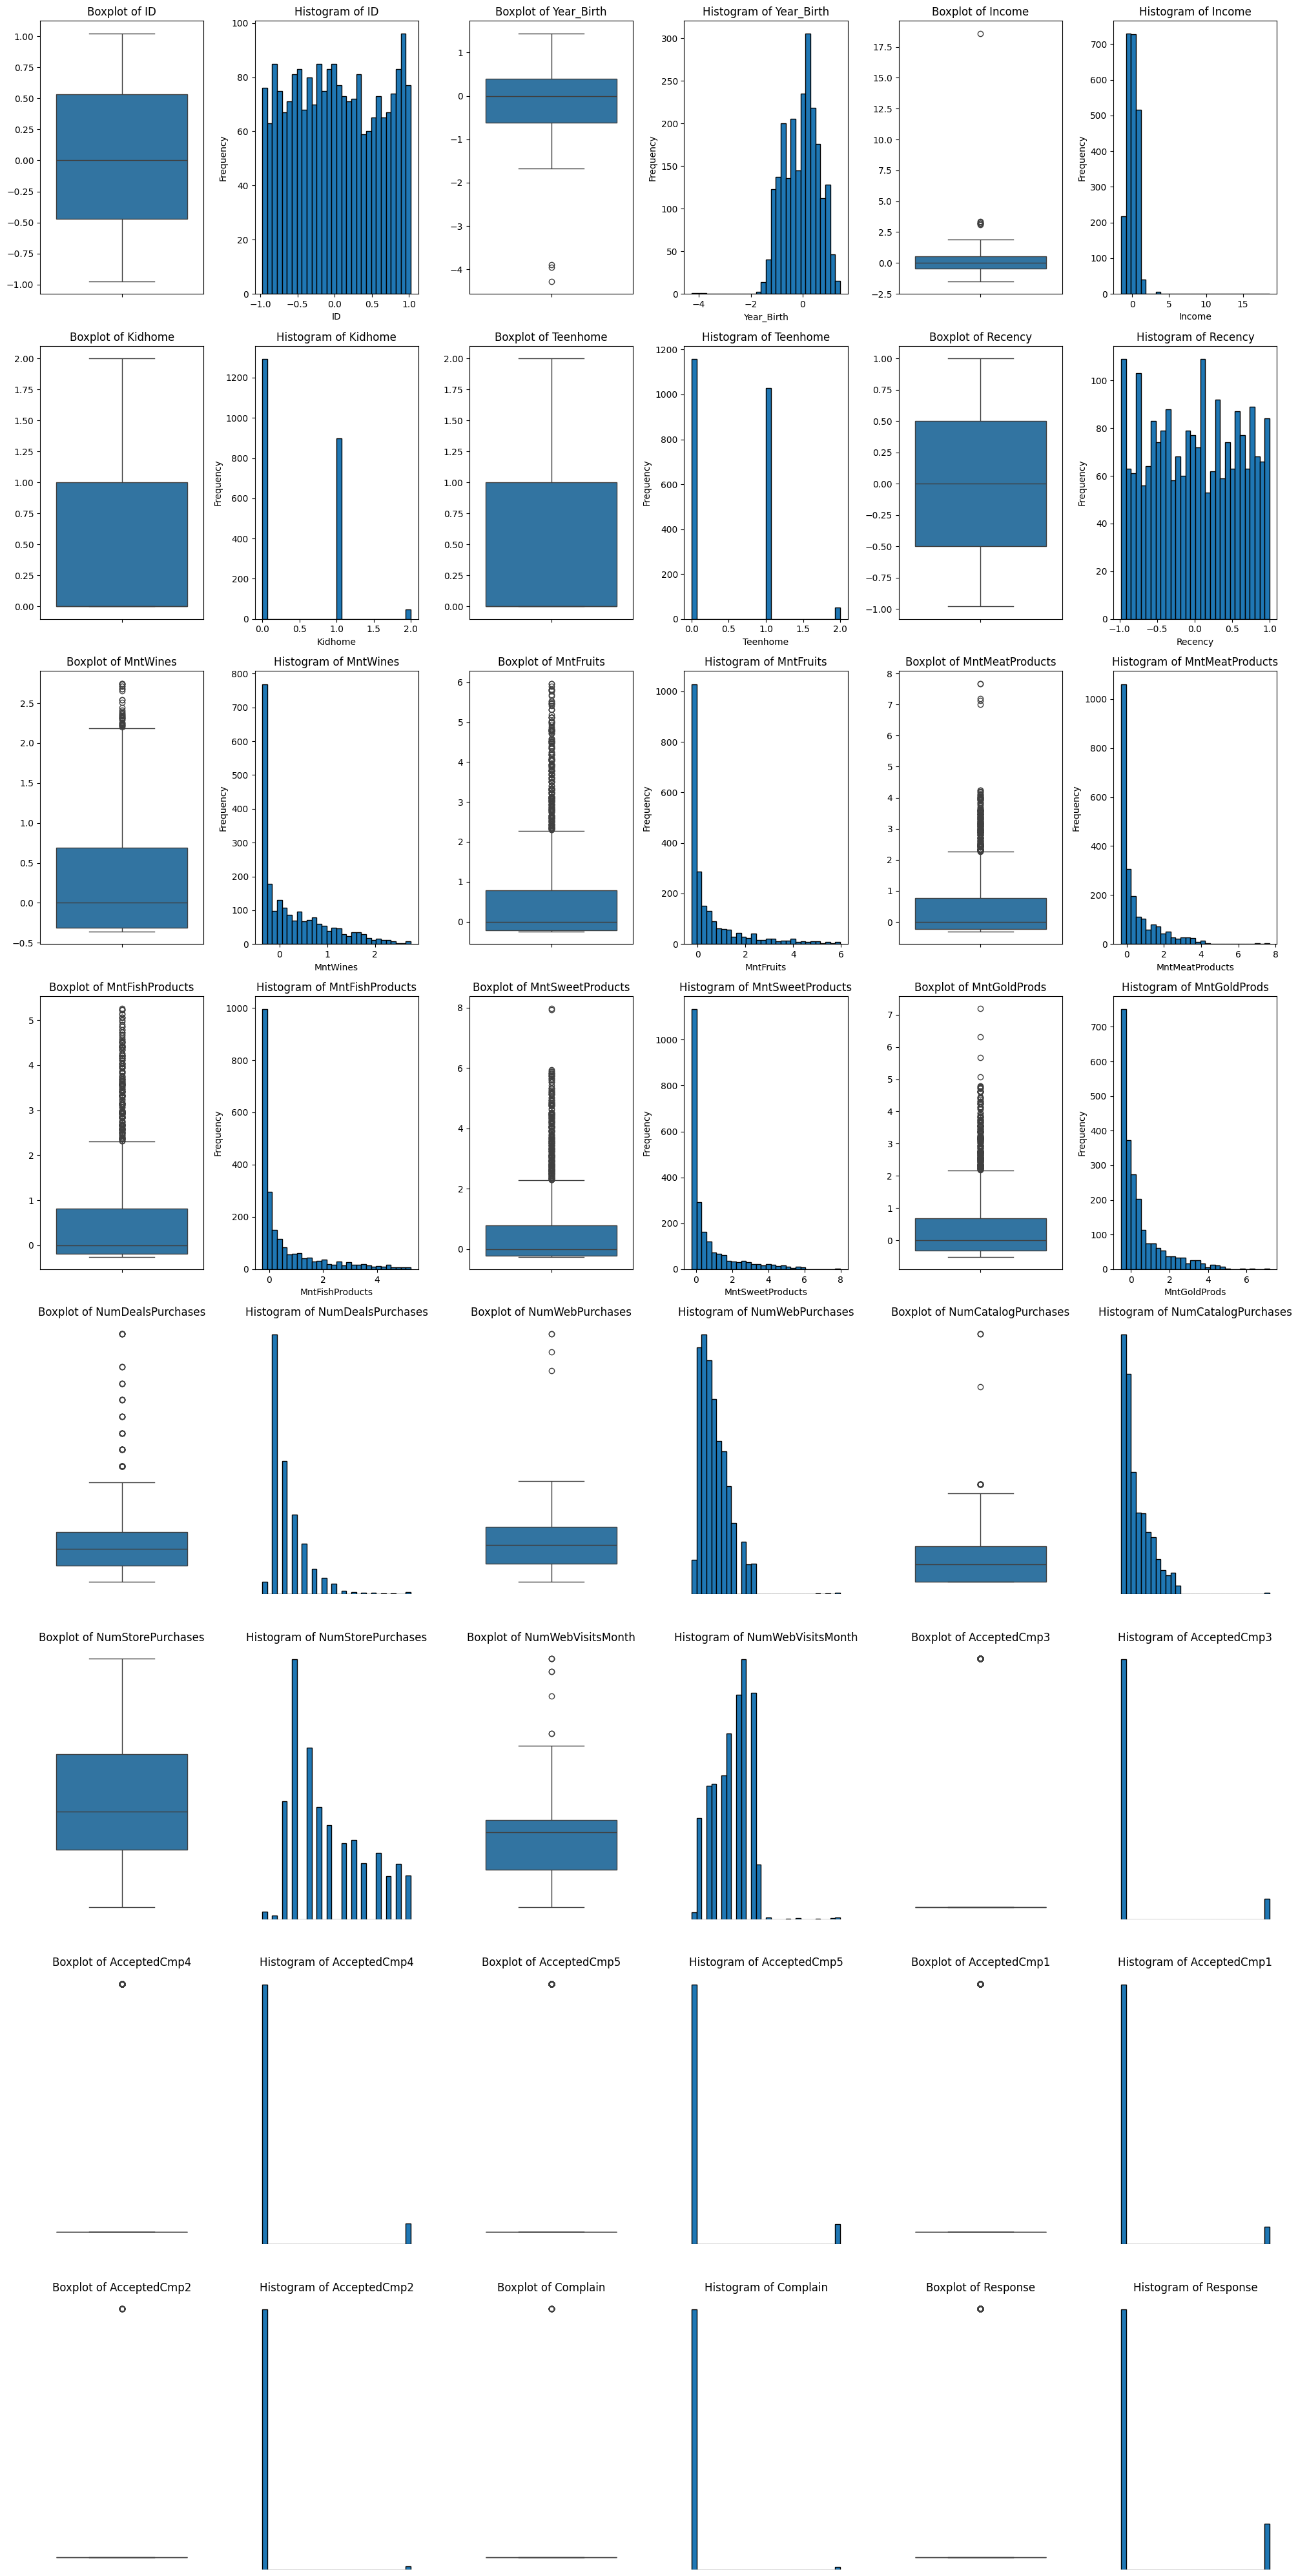

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n_cols = 3  # Adjust the number of columns as needed
n_rows = (len(final_df.select_dtypes(include='number').columns) // n_cols) + (len(final_df.select_dtypes(include='number').columns) % n_cols > 0)  # Calculate rows needed

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(20, 5 * n_rows))  # Double the number of columns to accommodate both boxplot and histogram

# Flatten axes array for easy iteration if there are multiple rows
axes = axes.flatten()

# Loop through each column and create a boxplot and histogram
for i, col in enumerate(final_df.select_dtypes(include='number').columns):
    # Boxplot on the left
    sns.boxplot(ax=axes[2 * i], data=final_df[col])
    axes[2 * i].set_title(f'Boxplot of {col}')
    axes[2 * i].set_xlabel('')  # Optional: hide xlabel for clarity
    axes[2 * i].set_ylabel('')  # Optional: hide ylabel for clarity
    
    # Histogram on the right
    axes[2 * i + 1].hist(final_df[col], bins=30, edgecolor='black')
    axes[2 * i + 1].set_title(f'Histogram of {col}')
    axes[2 * i + 1].set_xlabel(col)
    axes[2 * i + 1].set_ylabel('Frequency')

# Hide any unused subplots (if the number of columns is not a perfect multiple of n_cols)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## 1 K-means ++ PCA 2D

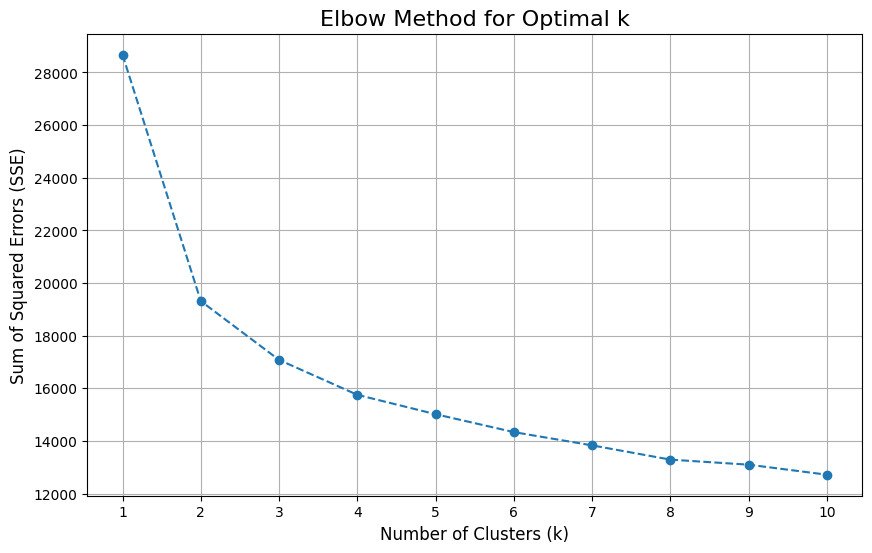

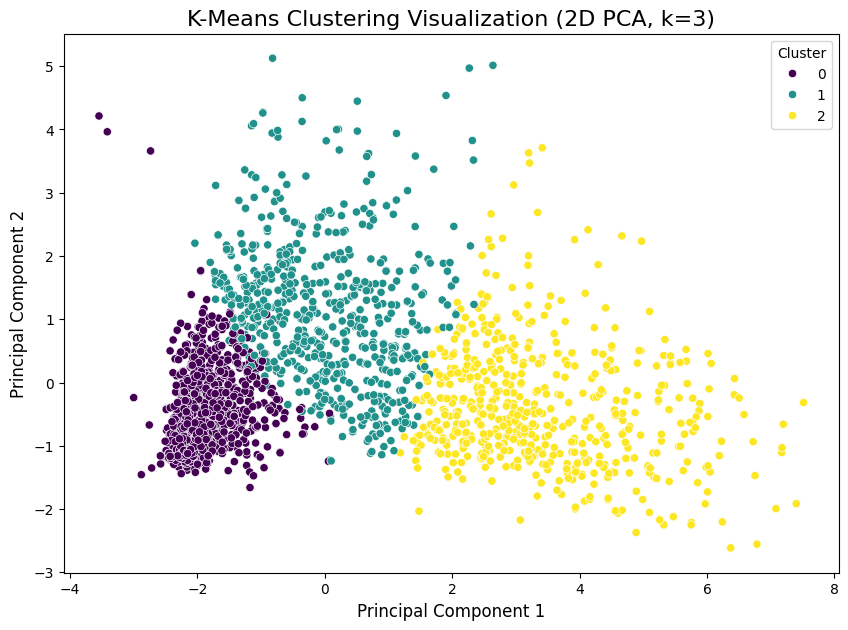

In [43]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Copy of the scaled data
data_scaled_df_k = data_numerical.copy()

# Step 1: Determine the optimal number of clusters using the elbow method
sse = []  # Sum of Squared Errors
k_range = range(1, 11)  # Test k values from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(data_scaled_df_k)
    sse.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Sum of Squared Errors (SSE)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Step 2: Apply K-Means++ with the optimal number of clusters
optimal_k = 3  # Replace with the elbow point identified from the plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++')
data_scaled_df_k['Cluster'] = kmeans.fit_predict(data_scaled_df_k)

# Add clusters to the final dataframe
final_df['Cluster'] = data_scaled_df_k['Cluster']

# Step 3: PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled_df_k.drop(columns='Cluster'))
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = data_scaled_df_k['Cluster']

# Step 4: Visualization of the Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=reduced_df, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title(f'K-Means Clustering Visualization (2D PCA, k={optimal_k})', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.show()


## 2 K-means++ - PCA en 3D

In [44]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Select relevant features for segmentation
features = ['Income', 'MntWines', 'MntMeatProducts', 'NumWebPurchases', 'Recency']
X = final_df[features].dropna()  # Drop rows with missing values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
X['Cluster'] = kmeans.fit_predict(X_scaled)  # Add clusters to the feature data only

# Perform PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for PCA results
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
X_pca_df['Cluster'] = X['Cluster']

# Plotly 3D Scatter Plot
fig = px.scatter_3d(
    X_pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='3D Visualization of K-Means Clustering (PCA)',
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'},
    color_continuous_scale='Viridis'
)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(scene=dict(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    zaxis_title='Principal Component 3'
))

# Show the interactive plot
fig.show()


## 3 Pipeline MLP prédiction des comportements d'achat

Epoch 1/100


c:\Users\Julien\miniconda3\envs\PCD\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4892
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0398
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8399
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8574
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7817
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8535
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7700
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7908
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8153
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7105
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7542
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7969
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6916
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6815
Epoch 15/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7095
Epoch 16/100
56/

c:\Users\Julien\miniconda3\envs\PCD\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning:

This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.



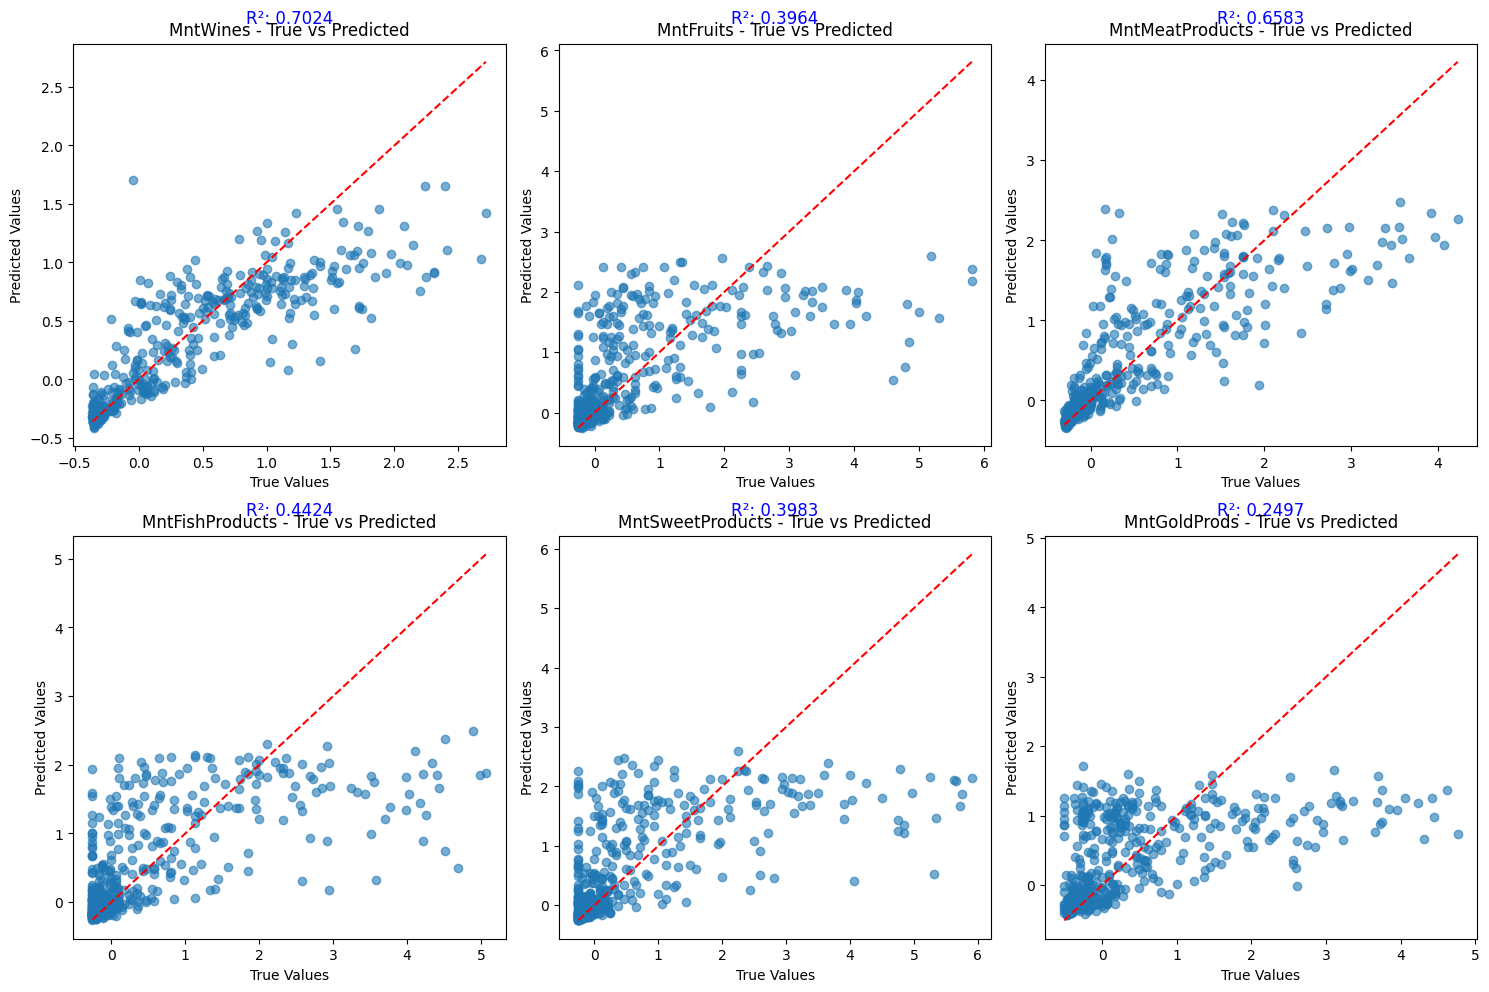

In [45]:
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define a custom Keras regressor class
class CustomKerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, epochs=100, batch_size=32):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def create_model(self, input_dim):
        model = Sequential([
            Dense(64, activation='relu', input_dim=input_dim),  # Input layer
            Dropout(0.3),  # Dropout to prevent overfitting
            Dense(32, activation='relu'),  # Hidden layer
            Dropout(0.3),  # Dropout layer
            Dense(len(target_features), activation='linear')  # Output layer
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit(self, X, y):
        input_dim = X.shape[1]
        self.model = self.create_model(input_dim)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Assuming data is preloaded, and we are focusing on the main parts
target_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Preprocessing pipeline
categorical_cols = data_numerical.select_dtypes(exclude='number').columns.tolist()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_cols)],
    remainder='passthrough'  # Leave numeric columns as they are
)

# Prepare the data
X = data_numerical.drop(columns=target_features)  # Features
y = data_numerical[target_features]  # Target variables

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the full pipeline (Preprocessing + Model)
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', CustomKerasRegressor(epochs=100, batch_size=32))
])

# Train the model
mlp_pipeline.fit(X_train, y_train)

# Step 8: Make predictions on the test set
y_pred = mlp_pipeline.predict(X_test)

# Step 9: Evaluate the model's performance
mse_overall = mean_squared_error(y_test, y_pred)
r2_overall = r2_score(y_test, y_pred)

print(f'Overall Mean Squared Error (MSE): {mse_overall:.4f}')
print(f'Overall R² Score: {r2_overall:.4f}')

# Individual target metrics
for i, feature in enumerate(target_features):
    mse_feature = mean_squared_error(y_test[feature], y_pred[:, i])
    r2_feature = r2_score(y_test[feature], y_pred[:, i])
    print(f'{feature} - Mean Squared Error (MSE): {mse_feature:.4f}')
    print(f'{feature} - R² Score: {r2_feature:.4f}')

# Step 10: Visualize predictions vs true values for each target feature with R² above each plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, feature in enumerate(target_features):
    ax = axes[i // 3, i % 3]
    ax.scatter(y_test[feature], y_pred[:, i], alpha=0.6)
    ax.set_title(f'{feature} - True vs Predicted')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.plot([y_test[feature].min(), y_test[feature].max()],
            [y_test[feature].min(), y_test[feature].max()], color='red', linestyle='--')
    
    r2_feature = r2_score(y_test[feature], y_pred[:, i])
    ax.annotate(f'R²: {r2_feature:.4f}', xy=(0.5, 1.05), xycoords='axes fraction', ha='center', fontsize=12, color='blue')

plt.tight_layout()
plt.show()


## 

## 4 Prédiction du revenu client avec random forest

MSE: 0.0648, R²: 0.8390


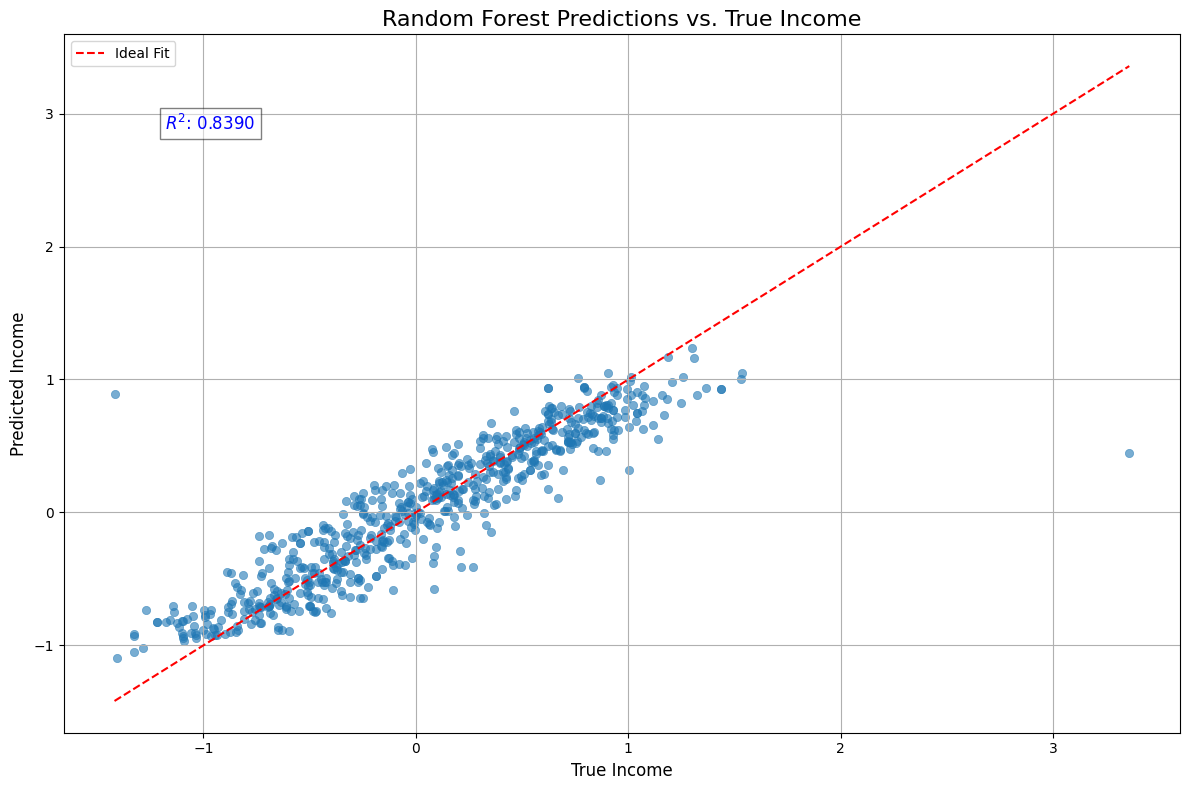

In [46]:

	import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define target (CLV proxy) and features
y = final_df['Income']  # Proxy for lifetime value
X = final_df.drop(columns=['Income', 'ID', 'Cluster'], errors='ignore')

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.4f}, R²: {r2:.4f}')

# Visualize true vs. predicted values
plt.figure(figsize=(12, 8))  # Increase the figure size for more space
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.title('Random Forest Predictions vs. True Income', fontsize=16)
plt.xlabel('True Income', fontsize=12)
plt.ylabel('Predicted Income', fontsize=12)
plt.legend()

# Add R² text to the plot
plt.text(
    x=y_test.min() + (y_test.max() - y_test.min()) * 0.05,  # Position x
    y=y_test.max() - (y_test.max() - y_test.min()) * 0.1,  # Position y
    s=f'$R^2$: {r2:.4f}', fontsize=12, color='blue', bbox=dict(facecolor='white', alpha=0.5)
)

plt.grid(True)
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


## 5 Prédiction efficacité des campagnes marketing GradientBoosting

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       577
         1.0       0.58      0.27      0.37        95

    accuracy                           0.87       672
   macro avg       0.73      0.62      0.65       672
weighted avg       0.85      0.87      0.85       672



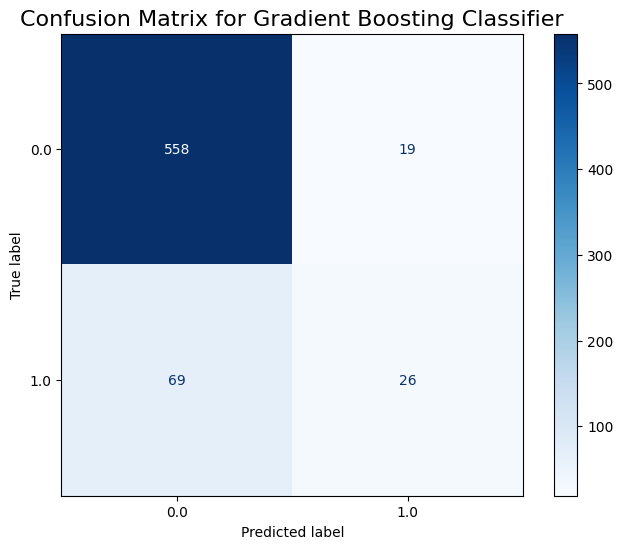

In [47]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Define target and features
y = final_df['Response']  # Response to campaigns
X = final_df.drop(columns=['Response', 'ID'], errors='ignore')
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Gradient Boosting Classifier
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train, y_train)

# Evaluate model
y_pred = gbc_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=gbc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbc_model.classes_)

# Customize the plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix for Gradient Boosting Classifier", fontsize=16)
plt.show()


## 6 analyse des préférences selon catégories de produit

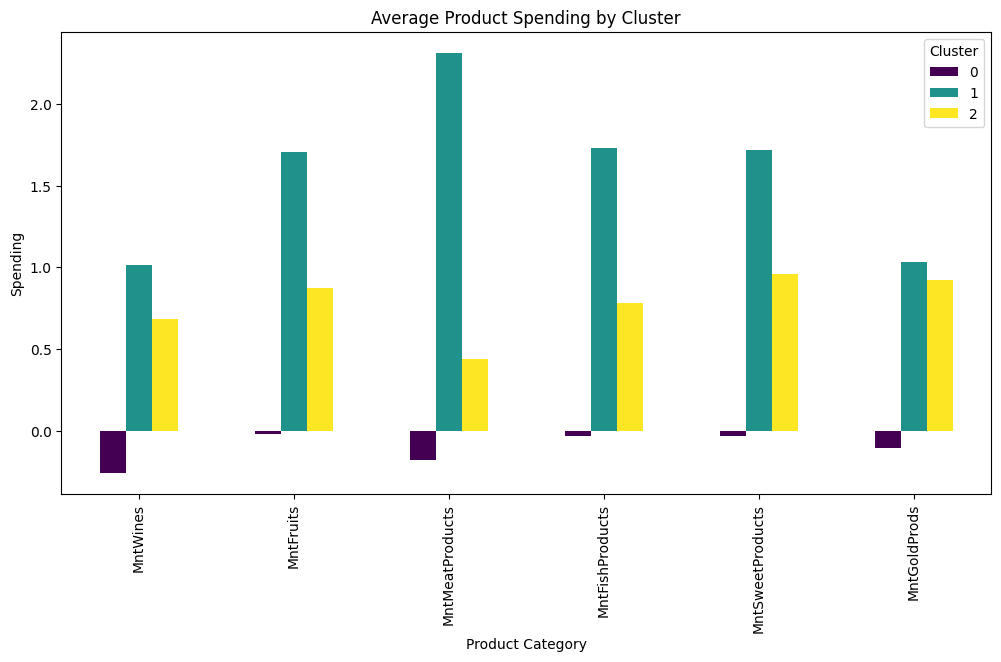

In [48]:
import seaborn as sns
kmeans = KMeans(n_clusters=3, random_state=42)
final_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Summarize product spending by cluster
product_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
cluster_summary = final_df.groupby('Cluster')[product_features].mean()

# Visualize
cluster_summary.T.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Average Product Spending by Cluster')
plt.ylabel('Spending')
plt.xlabel('Product Category')
plt.legend(title='Cluster')
plt.show()


## 7 Prédiction du 'churn' client avec un modèle de régression logistique

Accuracy: 0.9836
Confusion Matrix:
 [[483   1]
 [ 10 178]]


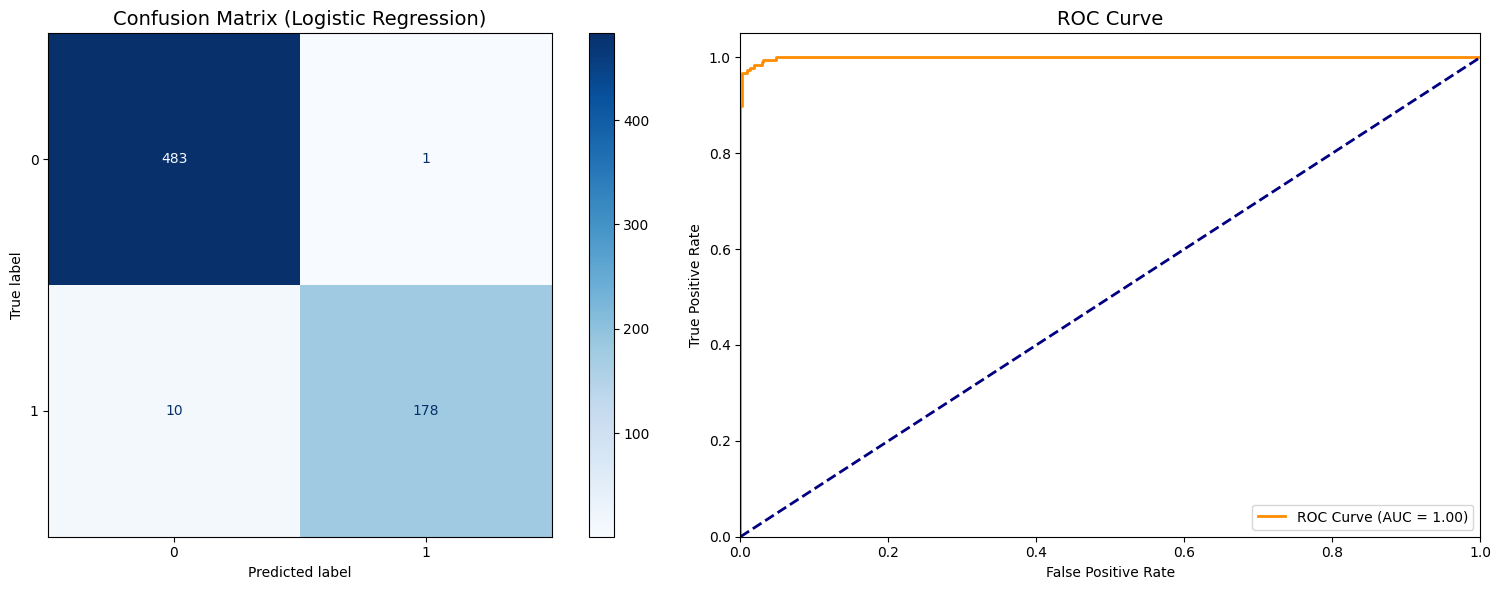

In [49]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


final_df['Churn'] = (final_df['Recency'] > final_df['Recency'].quantile(0.75)).astype(int)
y = final_df['Churn']
X = final_df.drop(columns=['Churn', 'ID'], errors='ignore')
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Evaluate model
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot confusion matrix
disp.plot(cmap="Blues", ax=ax[0])
ax[0].set_title("Confusion Matrix (Logistic Regression)", fontsize=14)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_title('ROC Curve', fontsize=14)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


## 8 Durée de vie d'un client avec un random forest regressor

R² Score: 0.9975
MSE: 0.0591


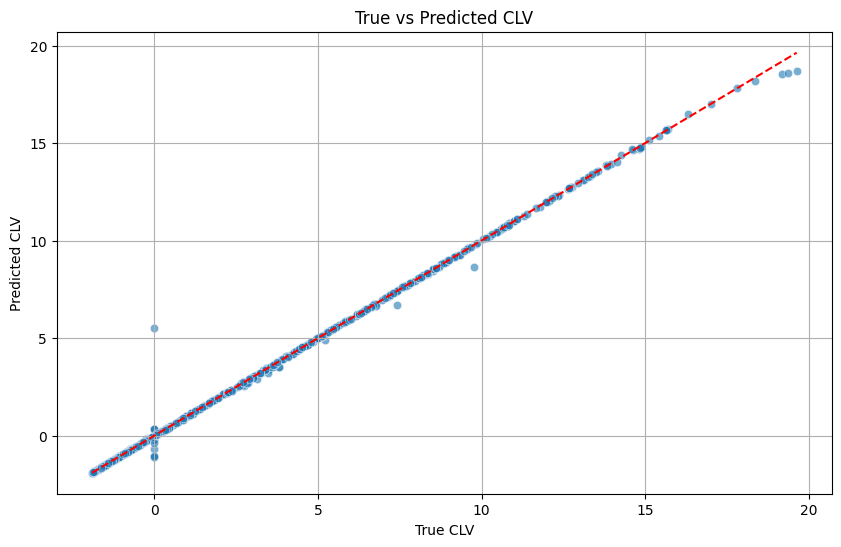

In [50]:
# Feature engineering for CLV
#CLV = (TotalSpending / NumPurchases) * NumPurchases
final_df['TotalSpending'] = (
    final_df['MntWines'] +
    final_df.get('MntFruits', 0) +
    final_df.get('MntMeatProducts', 0) +
    final_df.get('MntFishProducts', 0) +
    final_df.get('MntSweetProducts', 0) +
    final_df.get('MntGoldProds', 0)
)
final_df['NumPurchases'] = (
    final_df['NumWebPurchases'] +
    final_df.get('NumCatalogPurchases', 0) +
    final_df.get('NumStorePurchases', 0)
)

final_df['AveragePurchaseValue'] = final_df['TotalSpending'] / (final_df['NumPurchases'] + 1e-6)  # Avoid division by zero
final_df['CLV'] = final_df['AveragePurchaseValue'] * final_df['NumPurchases']

# Handle potential infinities or NaNs
final_df['CLV'] = final_df['CLV'].fillna(final_df['CLV'].median())

# ML: Predicting CLV
# Define features and target
X = final_df.drop(columns=['CLV'], errors='ignore').select_dtypes(include='number')  # Numeric features
y = final_df['CLV']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")

# Visualize predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('True vs Predicted CLV')
plt.xlabel('True CLV')
plt.ylabel('Predicted CLV')
plt.grid(True)
plt.show()



## 9 taux de conversion des clients (churn) avec un modèle de régression logistique

In [51]:
final_df.columns

Index(['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Education',
       'Marital_Status', 'Dt_Customer', 'Cluster', 'Churn', 'TotalSpending',
       'NumPurchases', 'AveragePurchaseValue', 'CLV'],
      dtype='object')

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
encoder = LabelEncoder()
data_non_numerical_encoded = data_non_numerical.apply(encoder.fit_transform)

X = pd.concat([data_numerical, data_non_numerical_encoded], axis=1)

# Target variable: Churn (assuming it's binary, 1 = Churned, 0 = Not Churned)
y = final_df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = lr_model.predict(X_test)

# Classification report and ROC AUC score
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]):.4f}")


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       484
           1       0.98      0.96      0.97       188

    accuracy                           0.98       672
   macro avg       0.98      0.98      0.98       672
weighted avg       0.98      0.98      0.98       672

ROC AUC Score: 0.9991


## 10 Score d'engagement CES avec un t-sne

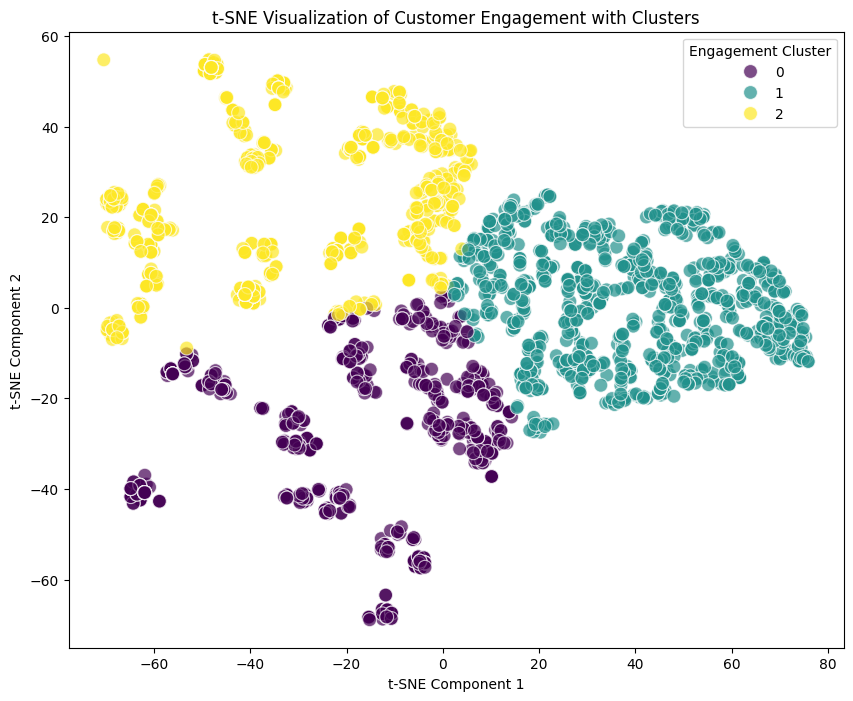

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant engagement features from the dataset
engagement_features = final_df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']]

# Standardize the engagement features
scaler = StandardScaler()
engagement_scaled = scaler.fit_transform(engagement_features)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
engagement_tsne = tsne.fit_transform(engagement_scaled)

# Create new columns for t-SNE coordinates
final_df['TSNE1'] = engagement_tsne[:, 0]
final_df['TSNE2'] = engagement_tsne[:, 1]

# Perform clustering directly on the t-SNE output
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
final_df['EngagementCluster'] = kmeans.fit_predict(engagement_tsne)  # Use t-SNE data for clustering

# Visualize the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE1', 
    y='TSNE2', 
    hue='EngagementCluster', 
    data=final_df, 
    palette='viridis', 
    s=100, 
    alpha=0.7
)
plt.title('t-SNE Visualization of Customer Engagement with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Engagement Cluster')
plt.show()


## 11 Visualisation de taux d'engagement selon le clustering

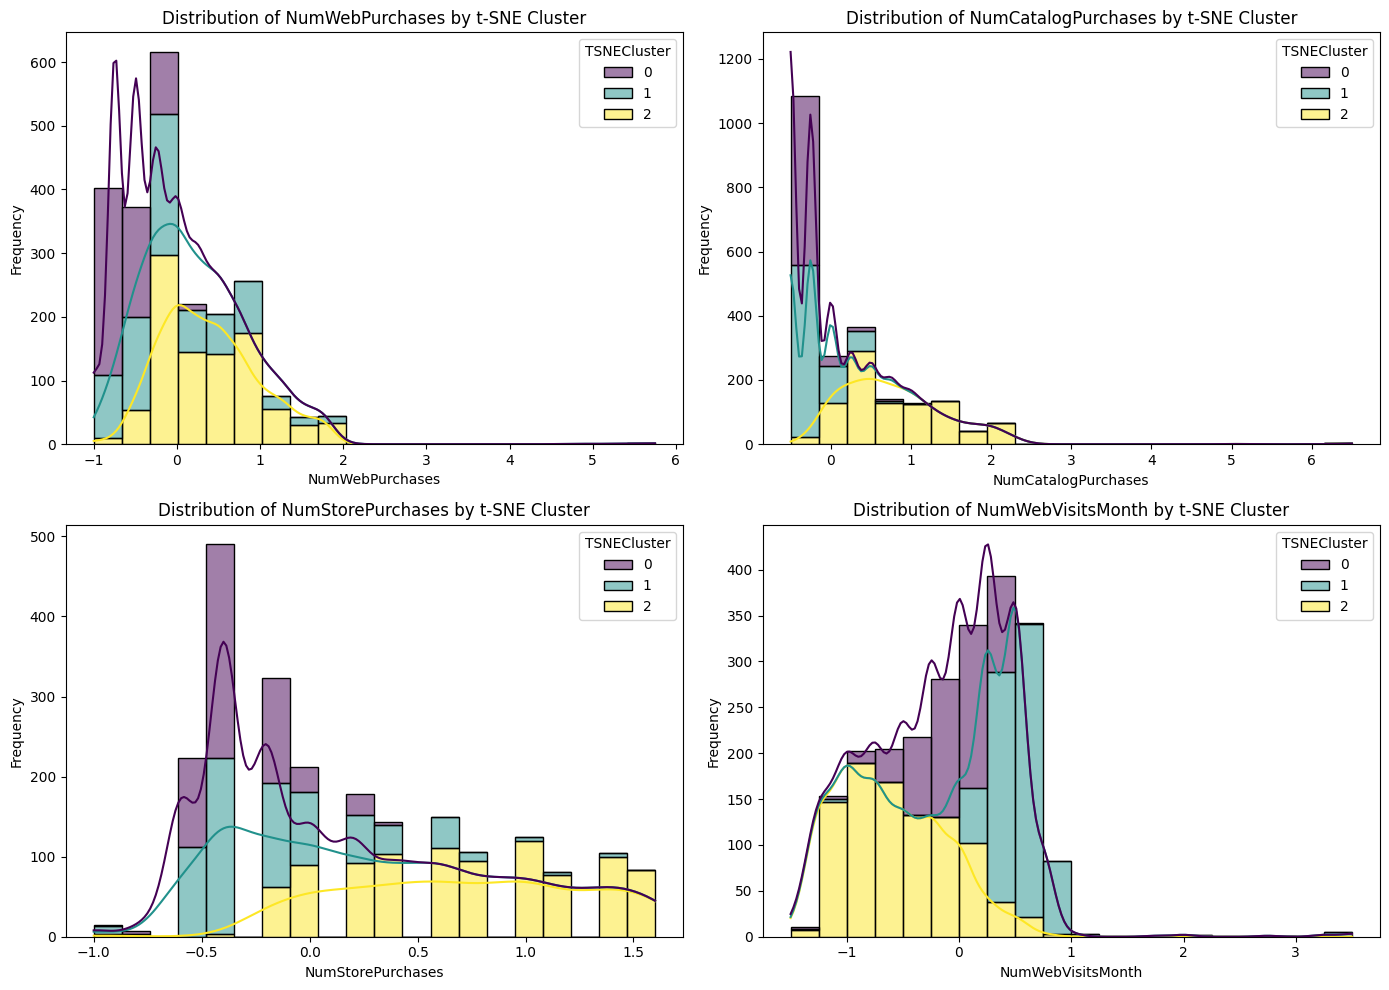

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Select relevant engagement features from the dataset
engagement_features = final_df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']]

# Standardize the engagement features
scaler = StandardScaler()
engagement_scaled = scaler.fit_transform(engagement_features)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
engagement_tsne = tsne.fit_transform(engagement_scaled)

# Add t-SNE components to the final dataframe
final_df['TSNE1'] = engagement_tsne[:, 0]
final_df['TSNE2'] = engagement_tsne[:, 1]

# Apply KMeans clustering on t-SNE components
kmeans_tsne = KMeans(n_clusters=3, random_state=42)
final_df['TSNECluster'] = kmeans_tsne.fit_predict(engagement_tsne)

# List of engagement features for visualization
engagement_columns = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

# Set up the plot
plt.figure(figsize=(14, 10))

# Plot histogram for each feature
for i, col in enumerate(engagement_columns, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    sns.histplot(data=final_df, x=col, hue='TSNECluster', kde=True, palette='viridis', multiple='stack', bins=20)
    plt.title(f'Distribution of {col} by t-SNE Cluster')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
